In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("car_prices.csv")
df.head()
df.shape

(558837, 16)

In [3]:
df['body'] = df['body'].str.replace('sedan', 'Sedan', case=False)
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)
df['month'] = df['saledate'].dt.month
sales_data = df.groupby(['make', 'model', 'month']).agg({'sellingprice': 'count'}).reset_index()
sales_data.rename(columns={'sellingprice': 'sales_count'}, inplace=True)
df = pd.merge(sales_data, df, on=['make', 'model', 'month'], how='left')
df = df.drop(["vin", "mmr", "state", "seller", "saledate", "trim"], axis = 1)

Statystyki opisowe

In [4]:
numerical_columns = ['year', 'condition', 'odometer','sellingprice','sales_count']
categorical_columns = ['make', 'model', 'body','color']

In [5]:
print("Statystyki opisowe:")
print(df[numerical_columns].describe().to_string())
print("Statystyki kategoryczne:")
print(df[categorical_columns].describe().to_string())

Statystyki opisowe:
                year      condition       odometer   sellingprice    sales_count
count  548400.000000  536693.000000  548310.000000  548400.000000  548400.000000
mean     2010.114026      30.776369   67538.840942   13689.292403    1043.376411
std         3.909040      13.376144   52908.383377    9701.956786    1163.864923
min      1984.000000       1.000000       1.000000       1.000000       1.000000
25%      2008.000000      24.000000   28143.250000    7000.000000     218.000000
50%      2012.000000      35.000000   51410.000000   12200.000000     618.000000
75%      2013.000000      42.000000   97924.000000   18300.000000    1435.000000
max      2015.000000      49.000000  999999.000000  230000.000000    6143.000000
Statystyki kategoryczne:
          make   model    body   color
count   548400  548400  545506  547671
unique      96     973      85      20
top       Ford  Altima   Sedan   black
freq     93553   19349  241234  109107


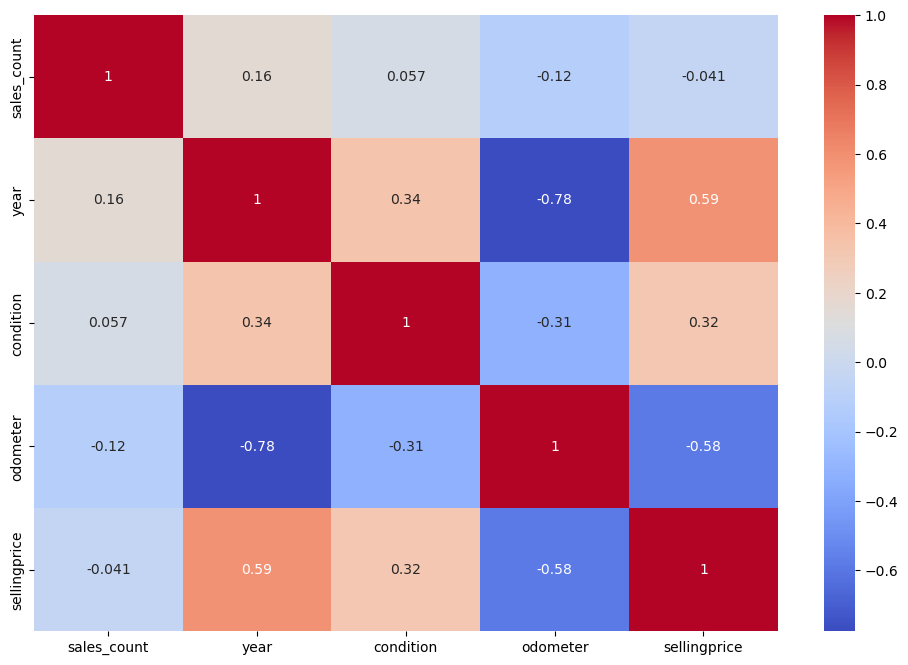

In [6]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
if 'month' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['month'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
#Distribution of year production all cars
YEAR = df['year'].value_counts()
fig = px.bar(YEAR, 
             labels={'index': 'Rok produkcji', 'value': 'Liczba samochodów'})

fig.update_layout(
    xaxis_title="Rok produkcji",
    yaxis_title="Liczba samochodów",
    showlegend=False
)
fig.show()

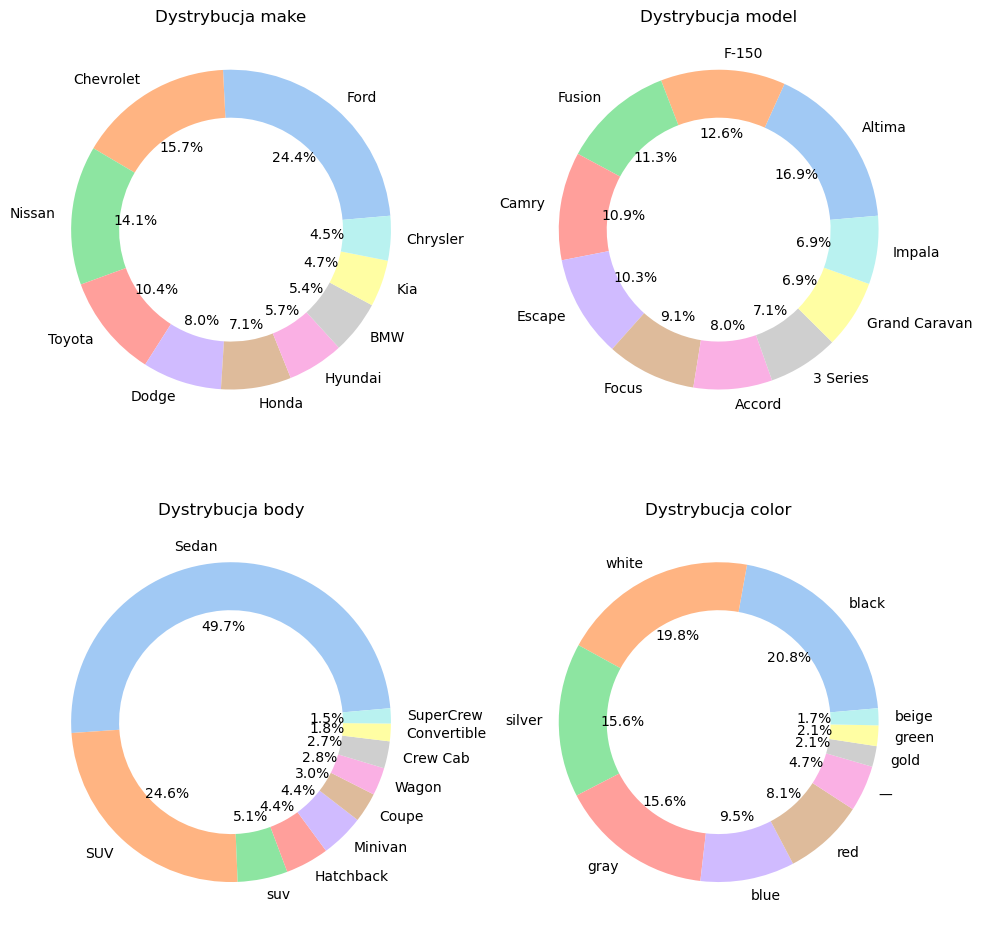

In [8]:
#Distribution of make,model,body, color
def plot_pie_chart_subplot(ax, column):
    ax.pie(df[column].value_counts().head(10), 
           labels=df[column].value_counts().head(10).index, 
           autopct='%1.1f%%', 
           startangle=5, 
           colors=sns.color_palette('pastel'), 
           wedgeprops=dict(width=0.3))
    ax.set_title(f'Dystrybucja {column}')
columns = ['make', 'model', 'body', 'color']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, col in zip(axes.flatten(), columns):
    plot_pie_chart_subplot(ax, col)
plt.tight_layout()
plt.show()



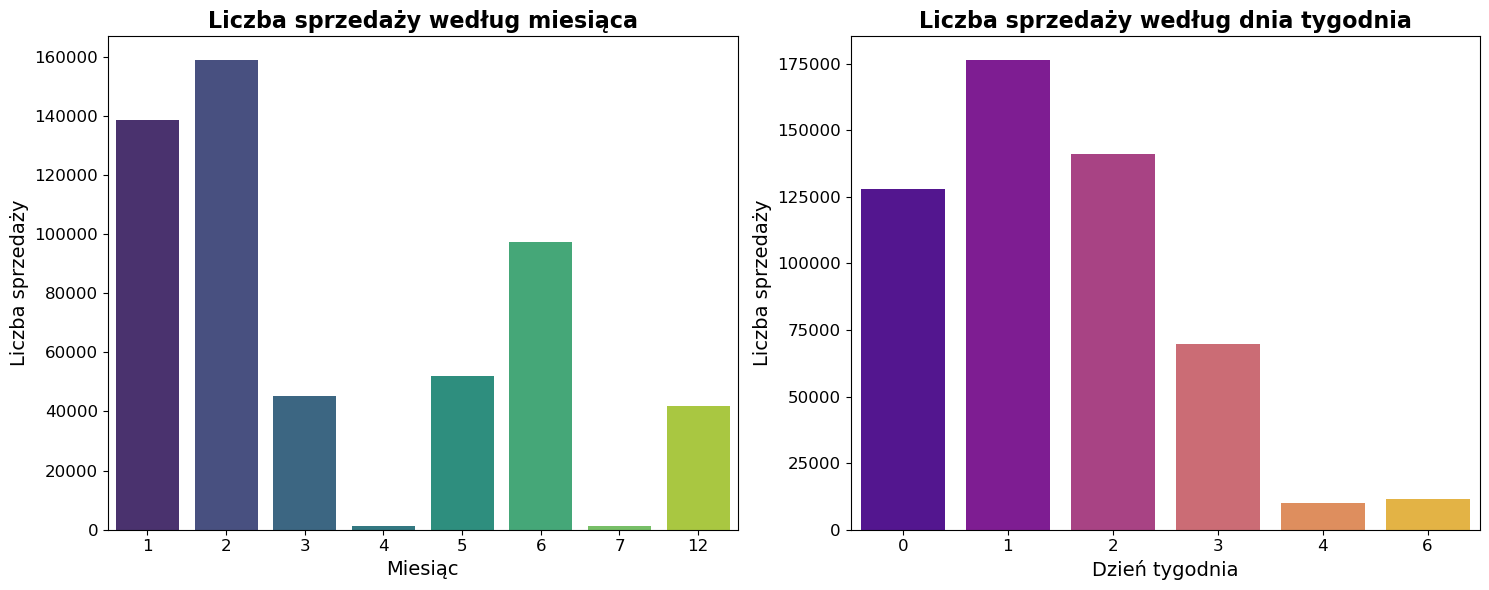

In [9]:
df1 =pd.read_csv("car_prices.csv")
df1 = df1.dropna(subset=['sellingprice', 'saledate', 'mmr', 'make', 'color', 'odometer', 'condition', 'interior'])
df1['saledate'] = pd.to_datetime(df1['saledate'], utc=True)
df1['sale_year'] = df1['saledate'].dt.year
df1['sale_month'] = df1['saledate'].dt.month
df1['sale_day'] = df1['saledate'].dt.day
df1['sale_dayofweek'] = df1['saledate'].dt.dayofweek
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='sale_month', data=df1, ax=axs[0], palette='viridis')
axs[0].set_title('Liczba sprzedaży według miesiąca', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Miesiąc', fontsize=14)
axs[0].set_ylabel('Liczba sprzedaży', fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
sns.countplot(x='sale_dayofweek', data=df1, ax=axs[1], palette='plasma')
axs[1].set_title('Liczba sprzedaży według dnia tygodnia', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Dzień tygodnia', fontsize=14)
axs[1].set_ylabel('Liczba sprzedaży', fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

Wtorek jest najbardziej szczytowym dniem sprzedaży, a luty jest najlepiej sprzedającym się miesiącem w danych

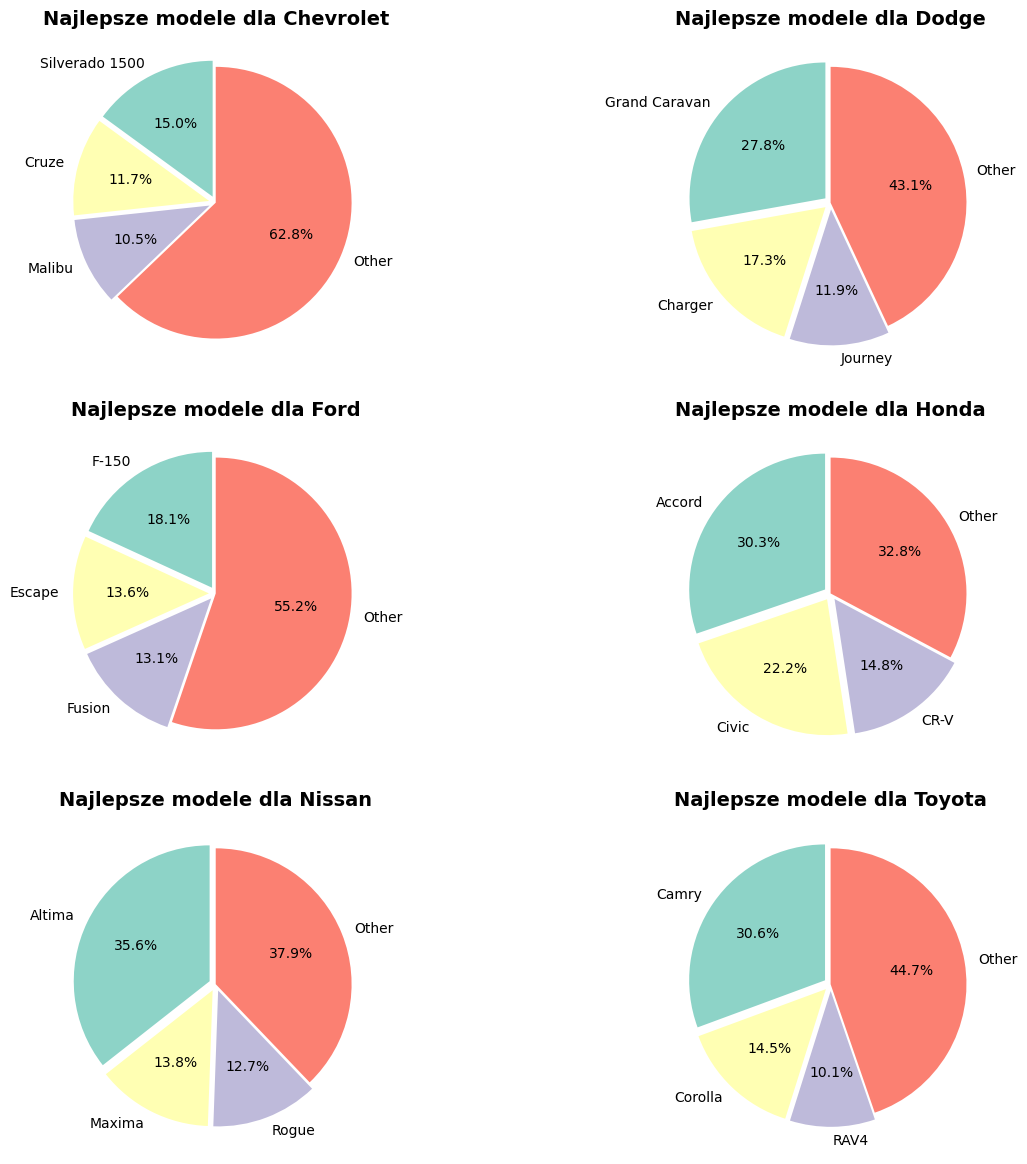

In [10]:
def outliers_handling(x, p1=0.25, p2=0.75):
    q1 = x.quantile(p1)
    q3 = x.quantile(p2)
    iqr = q3 - q1
    min_limit = q1 - 1.5 * iqr
    max_limit = q3 + 1.5 * iqr
    return x[(x > min_limit) & (x < max_limit)]

for col in ['odometer','mmr','sellingprice']:
    df1[col] = outliers_handling(df1[col])

df1['Price_diff']=df1['sellingprice'] - df1['mmr']
df1['Price_diff'] = outliers_handling(df1['Price_diff'])
df1['sell_price']=df1['Price_diff']+ df1['mmr']
total_sales = df1.groupby(['make', 'model']).agg({'sell_price': 'sum'}).reset_index()
top_makes = total_sales.groupby('make')['sell_price'].sum().nlargest(6).index
top_models = total_sales[total_sales['make'].isin(top_makes)]
top_models = top_models.loc[top_models.groupby('make')['sell_price'].nlargest(3).reset_index(level=0, drop=True).index]
other_models = total_sales[total_sales['make'].isin(top_makes) & ~total_sales['model'].isin(top_models['model'])]
other_sales = other_models.groupby('make').agg({'sell_price': 'sum'}).reset_index()
other_sales['model'] = 'Other'
combined_top_models = pd.concat([top_models, other_sales], ignore_index=True)
plt.figure(figsize=(14, 12))

for i, make in enumerate(combined_top_models['make'].unique(), start=1):
    plt.subplot(3, 2, i)
    colors = plt.cm.get_cmap('Set3').colors
    data = combined_top_models[combined_top_models['make'] == make]
    sizes = data['sell_price']
    labels = data['model']
    explode = [0.05 if label != 'Other' else 0 for label in labels]
    plt.pie(sizes,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors[:len(sizes)],
            explode=explode,
            shadow=False)
    plt.title(f'Najlepsze modele dla {make}', fontsize=14, fontweight='bold')
plt.tight_layout(pad=2)
plt.show()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    return df

df2=pd.read_csv("car_prices.csv")
saledate = df2['saledate'].str.split(expand=True)[[1,2,3,4,5]]
df2['Datetime'] = pd.to_datetime(saledate[1] + ' ' + saledate[2].astype(str) + ' ' + saledate[3].astype(str) + ' ' + saledate[4] + ' ' + saledate[5])
df2['Datetime'] = pd.to_datetime(df2['Datetime'], utc=True)
df2 = df2.set_index(df2['Datetime'])
df2 = df2.drop(columns=['saledate'])
df2 = create_features(df2)

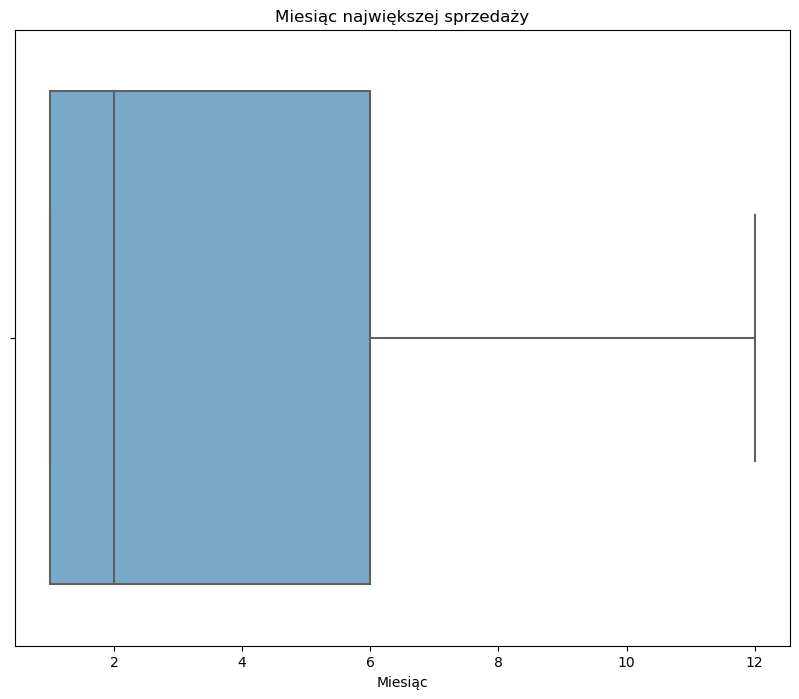

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='month', palette='Blues')
ax.set_title('Miesiąc największej sprzedaży')
ax.set_xlabel('Miesiąc')
plt.show()

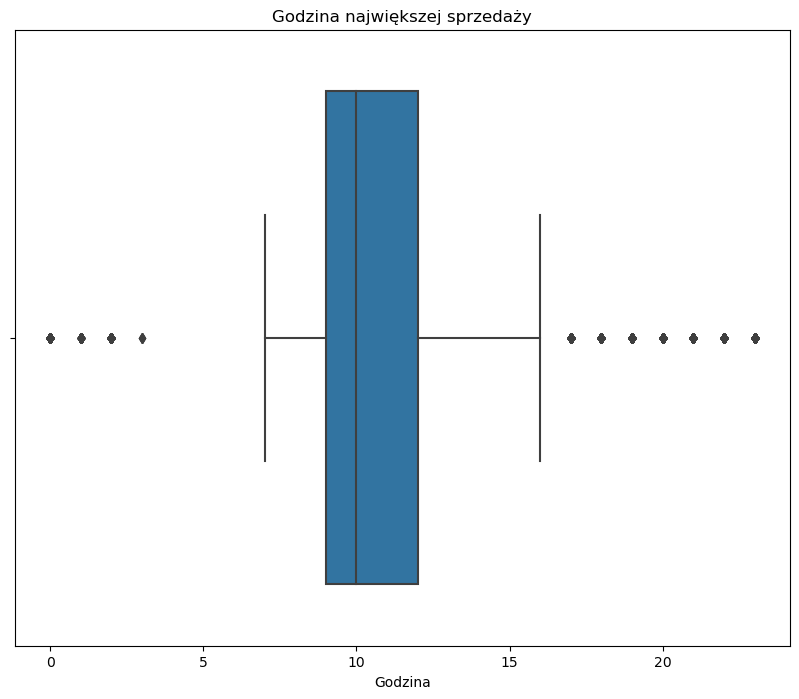

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='hour')
ax.set_title('Godzina największej sprzedaży')
ax.set_xlabel('Godzina')
plt.show()

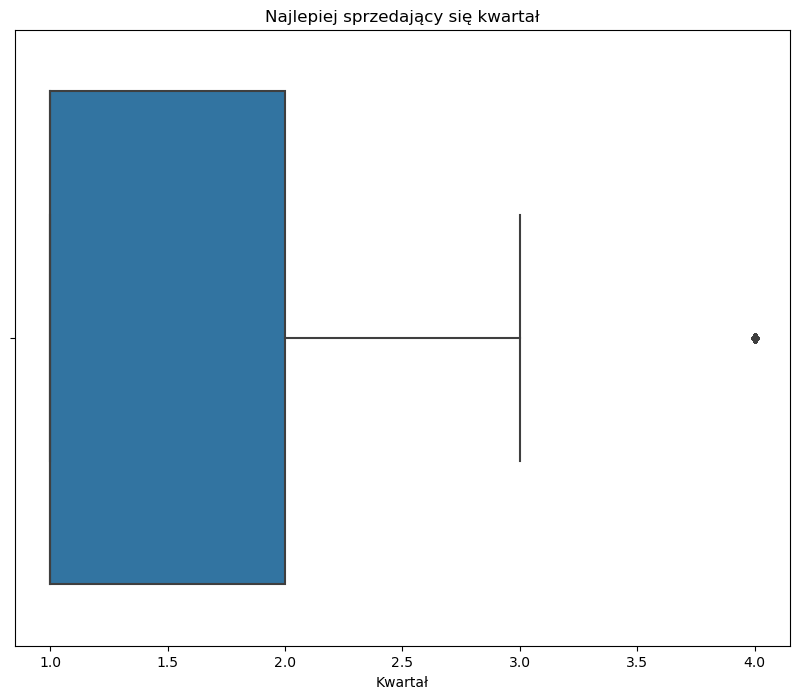

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='quarter')
ax.set_title('Najlepiej sprzedający się kwartał')
ax.set_xlabel('Kwartał')
plt.show()